In [1]:
from fitting import FitModel
from scipy import optimize
import numpy as np
import matplotlib.pyplot as plt
import input_checker as ic

In [3]:
params = {}
# params['core_shell'] = { 'Li': False, 'Ni': False, 'O': False }
# params['charges'] = {'Li': +1.0,
#                      'Ni': +3.0,
#                      'O': -2.0}
# params['masses'] = {'Li': 6.941,
#                     'Ni': 58.6934,
#                     'O': 15.999}
# params['cs_springs'] = {}


params['core_shell'] = { 'Li': False, 'Ni': False, 'O': True }
params['charges'] = {'Li': +1.0,
                     'Ni': +3.0,
                     'O': {'core':  -2.0, #+0.960,
                           'shell': 0.0}} #-2.960}}
params['masses'] = {'Li': 6.941,
                    'Ni': 58.6934,
                    'O': {'core': 14.3991,
                          'shell': 1.5999} }
params['cs_springs'] = {'O-O' : [20.0, 0.0]}


distribution = {}
distribution['Li-O'] = {'bpp' : [663.111, 0.119, 0.0],
                        'sd' : [80, 0.01, 0.01]}

distribution['Ni-O'] = {'bpp' : [1393.540, 0.218, 0.000],
                        'sd'  : [80, 0.01, 0.01]}

distribution['O-O'] = {'bpp' : [25804.807, 0.284, 0.0],
                       'sd'  : [200, 0.01, 5]}
       
excude_from_fit = [] # string of atom1_atom2_param. Example of format = 'O_O_rho'

In [5]:
# fit_data = FitModel.collect_info(params, distribution, supercell= [[2,2,2],[2,2,2],[2,2,2],[2,2,2],[8,4,2]])
fit_data = FitModel.collect_info(params, distribution, supercell=[2,2,2])

Found elements: ['Li', 'Ni', 'O']


In [6]:
include_labels = ['dq_O', 'q_scaling', 'O-O spring', 'Li_O_a',     'Li_O_rho', 'Ni_O_a',      'Ni_O_rho', 'O_O_a',        'O_O_rho']
bounds_list = [(0.01, 4), (0.3,1.0),   (10.0,150.0), (100.0,50000.0),(0.01,1.0), (150.0,50000.0),(0.01,1.0), (150.0,50000.0),(0.01,1.0)]

In [7]:
if len(include_labels) != len(bounds_list):
    raise IndexError('include_labels and bounds_list are not of equal length. Check there are bounds associated with each label with the correct bound values.')

for label, bounds in zip(include_labels, bounds_list):
    if label.startswith('dq_'):
        ic.check_coreshell(label, bounds, fit_data)
    elif label == 'q_scaling':
        ic.check_scaling_limits(label, bounds)
    elif '-' in label:
        ic.check_spring(label, bounds, params)
    elif '_a' in label or '_rho' in label or '_c' in label:
        ic.check_buckingham(label, bounds, params)
    else:
        raise TypeError('Label {} is not a valid label type'.format(label))

In [8]:
s = optimize.differential_evolution(fit_data.fit_error,
                                    bounds=bounds_list,
                                    popsize=25,
#                                     tol=0.0001,
                                    args=([include_labels]),
                                    maxiter=2000,
                                    disp=True,
                                    init='latinhypercube',
                                    workers=-1)

/Users/lmm82/.pyenv/versions/3.7.3/lib/python3.7/site-packages/scipy/optimize/_differentialevolution.py:461: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  " updating='deferred'", UserWarning)


differential_evolution step 1: f(x)= 2.24808
differential_evolution step 2: f(x)= 0.725123
differential_evolution step 3: f(x)= 0.394472
differential_evolution step 4: f(x)= 0.394472
differential_evolution step 5: f(x)= 0.377916
differential_evolution step 6: f(x)= 0.377916
differential_evolution step 7: f(x)= 0.33642
differential_evolution step 8: f(x)= 0.301924
differential_evolution step 9: f(x)= 0.301924
differential_evolution step 10: f(x)= 0.301924
differential_evolution step 11: f(x)= 0.301924
differential_evolution step 12: f(x)= 0.301924
differential_evolution step 13: f(x)= 0.301924
differential_evolution step 14: f(x)= 0.301924
differential_evolution step 15: f(x)= 0.301924
differential_evolution step 16: f(x)= 0.301924
differential_evolution step 17: f(x)= 0.287678
differential_evolution step 18: f(x)= 0.265547
differential_evolution step 19: f(x)= 0.265547
differential_evolution step 20: f(x)= 0.239856
differential_evolution step 21: f(x)= 0.218984
differential_evolution s

In [9]:
s

     fun: 0.1601920614348553
 message: 'Optimization terminated successfully.'
    nfev: 25885
     nit: 114
 success: True
       x: array([3.15909895e+00, 6.14871634e-01, 1.26398979e+01, 2.13866240e+04,
       1.65413241e-01, 5.86257774e+03, 2.03697561e-01, 3.81802139e+03,
       2.12089019e-01])

In [10]:
def fit_forces(fit_data, values, args):
    potential_params = dict(zip( args, np.round(values,4) ))
    for pot in fit_data.potentials:
        for param in [ pot.a, pot.rho, pot.c ]:
            key = param.label_string
            if key not in potential_params:
                potential_params[key] = param.value
    print(potential_params)
    ip_forces = fit_data.get_forces()
    return ip_forces

In [11]:
include_values = s.x[3:]
ip_list = np.concatenate(fit_forces(fit_data, include_values, include_labels[3:]), axis=0)
dft_list = np.concatenate(fit_data.expected_forces(), axis=0)

np.savetxt('dft_forces.txt', dft_list, fmt='%.10e', delimiter=' ')
np.savetxt('ip_forces.txt', ip_list, fmt='%.10e', delimiter=' ')

{'Li_O_a': 21386.624, 'Li_O_rho': 0.1654, 'Ni_O_a': 5862.5777, 'Ni_O_rho': 0.2037, 'O_O_a': 3818.0214, 'O_O_rho': 0.2121, 'Li_O_c': 0.0, 'Ni_O_c': 0.0, 'O_O_c': 0.0}


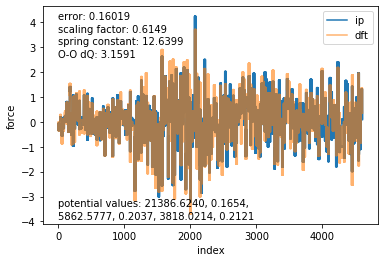

In [17]:
plt.plot(ip_list, label='ip')
plt.plot(dft_list, label='dft', alpha=0.6)
plt.ylabel('force')
plt.xlabel('index')
plt.legend(loc='upper right')
plt.text(0,4.1, 'error: {0:.5f}'.format(np.sum(((dft_list-ip_list)**2)/ip_list.size)))
plt.text(0,3.6, 'scaling factor: {:.4f}'.format(s.x[1]))
plt.text(0,3.1, 'spring constant: {:.4f}'.format(s.x[2]))
plt.text(0,2.6, 'O-O dQ: {:.4f}'.format(s.x[0]))
plt.text(0,-3.4, 'potential values: {:.4f}, {:.4f},'.format(*include_values[:2]))
plt.text(0,-3.9, '{:.4f}, {:.4f}, {:.4f}, {:.4f}'.format(*include_values[2:]))

plt.savefig('q+buck+cs+spring+ratio_1thermo.png',dpi=500, bbox_inches = "tight")
plt.show()
# np.sum(((dft_list-ip_list)**2)/ip_list.size)

In [ ]:
# plt.plot([1,0.9,0.8,0.7,0.6,0.5,0.4, 0.3, 0.2, 0.1],[1.91447, 1.15191, 0.64100, 0.3006, 0.16467, 0.10002, 0.09871, 0.12966, 0.16898, 0.19944], '-ok')
# plt.xlabel('charge scaling factor')
# plt.ylabel('MSE')
# plt.savefig('charge_scaling_error_plot.png',dpi=500, bbox_inches = "tight")
# plt.show()

In [ ]:
# plt.plot([1, 2, 3, 4, 5, 6, 7, 8],[0.25289, 0.27519, 0.28708, 0.29331, 0.30346, 0.30094, 0.30782, 0.30310], '-ok')
# plt.xlabel('number of structures')
# plt.ylabel('fit error')
# plt.savefig('error_vs_numStructure.png',dpi=500, bbox_inches = "tight")
# plt.show()

Get Lattice Parameters

In [ ]:
import lammps
def get_lattice(fit_data):
    potential_params = {}
    for pot in fit_data.potentials:
        for param in [pot.a, pot.rho, pot.c]:
            key = param.label_string
            potential_params[key] = param.value
    lmp = fit_data.get_lattice_params(**potential_params)
    return lmp

In [ ]:
lmp = get_lattice(fit_data)
lammps = lmp[0]

In [ ]:
a_c_vol = [(lammps.box.lengths[0]/8),(lammps.box.lengths[2]/2),lammps.box.volume/8/4/2/2]
ref_delmas = [2.879, 14.201, 101.951]

In [ ]:
a_dif = (a_c_vol[0]-ref_delmas[0])/((a_c_vol[0]+ref_delmas[0])/2) * 100
c_dif = (a_c_vol[1]-ref_delmas[1])/((a_c_vol[1]+ref_delmas[1])/2) * 100
vol_dif = (a_c_vol[2]-ref_delmas[2])/((a_c_vol[2]+ref_delmas[2])/2) * 100

In [ ]:
print('My calculated values are (a,c,vol): {}'.format(a_c_vol))
print('Experimental values are (a,c,vol): {}'.format(ref_delmas))
print('Percentage differences are (a,c,vol): {}, {}, {}'.format(a_dif, c_dif, vol_dif))

In [ ]:
ref_DFT = [2.729, 14.053, 96.456]

In [ ]:
a_dif = (a_c_vol[0]-ref_DFT[0])/((a_c_vol[0]+ref_DFT[0])/2) * 100
c_dif = (a_c_vol[1]-ref_DFT[1])/((a_c_vol[1]+ref_DFT[1])/2) * 100
vol_dif = (a_c_vol[2]-ref_DFT[2])/((a_c_vol[2]+ref_DFT[2])/2) * 100

In [ ]:
print('My calculated values are (a,c,vol): {:.3f} {:.3f} {:.3f}'.format(a_c_vol[0], a_c_vol[1], a_c_vol[2]))
print('DFT values are (a,c,vol): {:.3f} {:.3f} {:.3f}'.format(ref_DFT[0], ref_DFT[1], ref_DFT[2]))
print('Percentage differences are (a,c,vol): {:.3f} {:.3f} {:.3f}'.format(a_dif, c_dif, vol_dif))

In [ ]:
lammps.box.lengths

In [ ]:
# Geometry optimised structure:
#      fun: 0.00024535877391032265
#        x: array([6.63110880e+02, 1.19385635e-01, 1.39354000e+03, 2.17550689e-01,
#        2.58048072e+04, 2.84121273e-01])

In [ ]:
#      fun: 0.00020117218726958615
#        x: array([5.16859856e+02, 2.27622770e-01, 3.17959194e+02, 3.02641291e-01,
#        1.56010420e+04, 3.00961159e-01])

In [ ]:
#      fun: 2.9965469134567404e-05
#        x: array([1.57187515e+03, 2.38087128e-01, 2.18242730e+02, 5.40287127e-01,
#        3.67954544e+04, 3.99826009e-02])

In [ ]:
#      fun: 0.00022146538630216886
#        x: array([1.99884762e+03, 1.97915567e-01, 1.92779928e+03, 2.00805359e-01,
#        2.23406599e+04, 2.91794009e-01])

In [ ]:
#      fun: 0.00021587433861985865
#        x: array([1.36449374e+03, 2.07769552e-01, 5.85016576e+02, 2.44567736e-01,
#        2.12183128e+04, 2.92891694e-01])

In [ ]:
#      fun: 0.0001749872704503645
#        x: array([1.27061887e+03, 2.08855364e-01, 3.21011122e+02, 3.30160472e-01,
#        8.15204948e+03, 3.24710512e-01])

In [ ]:
#      fun: 0.00024201340356503294
#        x: array([1.51933430e+03, 2.19804987e-01, 2.73284257e+03, 1.25871870e-01,
#        3.99602258e+04, 2.74290327e-01])

In [ ]:
#      fun: 3.0152162973553667e-05
#        x: array([1.61227502e+03, 2.36678924e-01, 2.18410497e+02, 5.39111493e-01,
#        1.18954090e+02, 2.72658396e-01])

In [ ]:
#      fun: 0.00020736598495354775
#        x: array([1.83446063e+03, 1.86905880e-01, 2.72859123e+02, 3.07100959e-01,
#        2.00429777e+04, 2.91059506e-01])

In [ ]:
# optimize.minimize(fit_data.fit_error, include_values, args=(include_labels), method='trust-constr', bounds=bounds_list, options={'xtol':0.001})